<a href="https://colab.research.google.com/github/cacress/CSC442/blob/main/Rithik_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

### Import cleaned and prepared dataset
df = pd.read_csv('https://raw.githubusercontent.com/cacress/CSC442/refs/heads/rithik_eda/datasets/rithik_eda_dataset.csv')

### This line is for pulling a "popular productions" subset of the data (717 productions with 50+ TMDB Popularity score)
df = df[df['tmdb_popularity'] >= 50]
print("Number of observations with tmdb_popularity >= 50:", df.shape[0])

Number of observations with tmdb_popularity >= 50: 717


In [2]:
### Add a simple neutrality measure that is extracted from sentiment scores.
### This will aid in regression analysis, since it is a closeness measure to 0 rather than in one of two opposite directions.
df['title_neutrality'] = 1 - df['title_sentiment'].abs()
df['description_neutrality'] = 1 - df['description_sentiment'].abs()

Principal Component Analysis and t-SNE Clustering for various text metric features

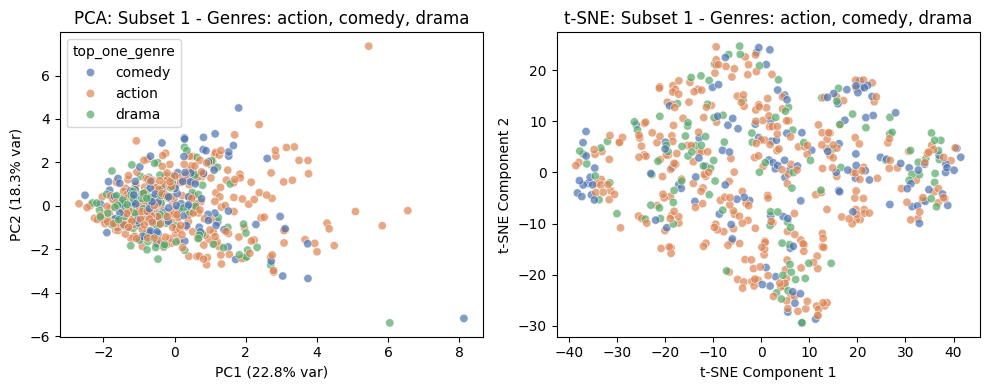

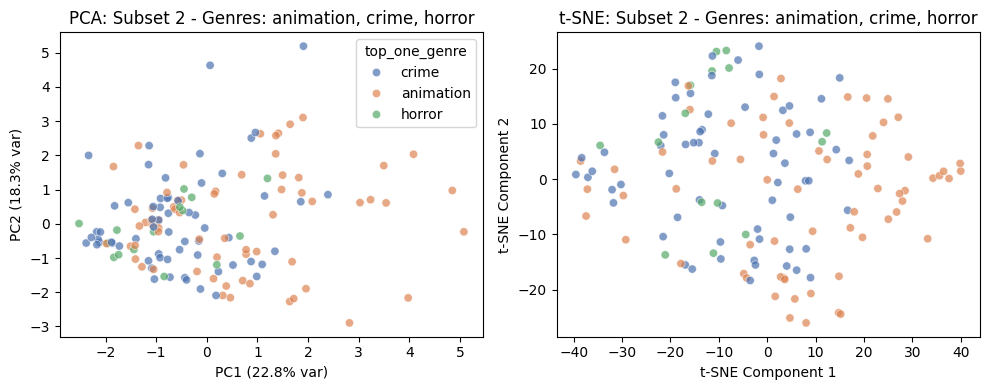

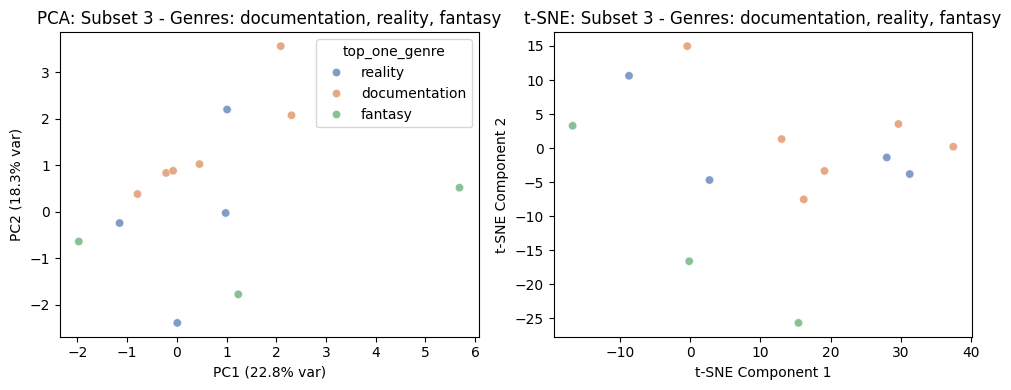

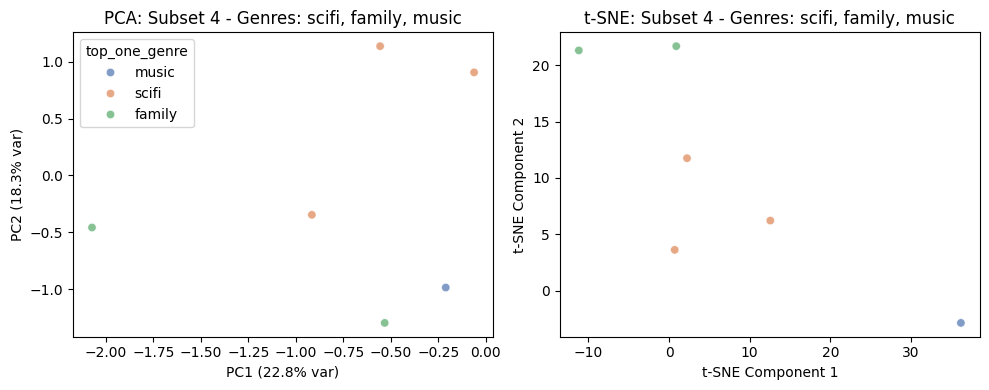

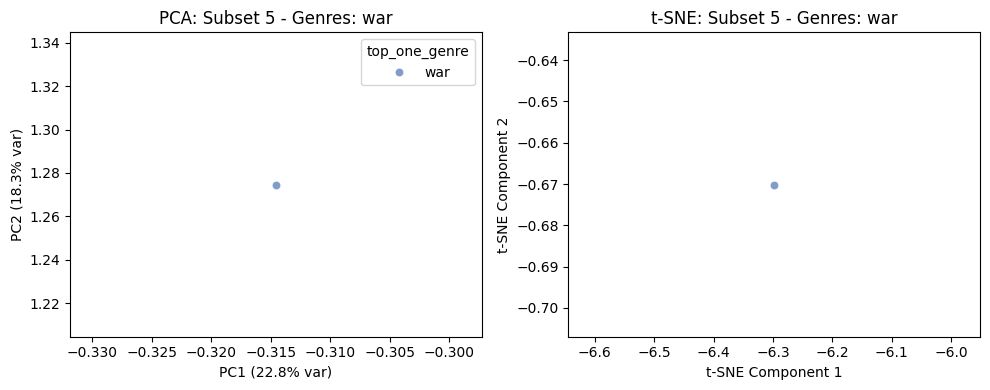

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Metrics to analyze
features = [
    'description_sentiment', 'title_sentiment',
    'description_neutrality', 'title_neutrality',
    'description_ari', 'title_ari',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count'
]

# Dropping empty genres and standardizing data
data = df[features + ['top_one_genre']].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# ----- PCA -----
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
pc1_label = f"PC1 ({explained_variance[0]*100:.1f}% var)"
pc2_label = f"PC2 ({explained_variance[1]*100:.1f}% var)"
data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]

# ----- t-SNE -----
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)
data['tsne1'] = data_tsne[:, 0]
data['tsne2'] = data_tsne[:, 1]

# Get the top 18 most frequent genres from top_one_genre and reorganize them into six subsets (3 per group)
genre_counts = data['top_one_genre'].value_counts()
top_genres = list(genre_counts.head(18).index)

# Take a subset of the data that only includes these top 18 genres
data_top = data[data['top_one_genre'].isin(top_genres)]

# Split into six further subsets
genre_groups = [top_genres[i:i+3] for i in range(0, len(top_genres), 3)]

# PCA and t-SNE plots
for idx, group in enumerate(genre_groups):
    subset_data = data_top[data_top['top_one_genre'].isin(group)]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # PCA plot
    sns.scatterplot(data=subset_data, x='pca1', y='pca2', hue='top_one_genre',
                    palette="deep", alpha=0.7, ax=axes[0])
    axes[0].set_title(f"PCA: Subset {idx+1} - Genres: {', '.join(group)}")
    axes[0].set_xlabel(pc1_label)
    axes[0].set_ylabel(pc2_label)

    # t-SNE plot
    sns.scatterplot(data=subset_data, x='tsne1', y='tsne2', hue='top_one_genre',
                    palette="deep", alpha=0.7, ax=axes[1])
    axes[1].set_title(f"t-SNE: Subset {idx+1} - Genres: {', '.join(group)}")
    axes[1].set_xlabel("t-SNE Component 1")
    axes[1].set_ylabel("t-SNE Component 2")

    # Cleaner plot legend
    axes[1].legend_.remove() if axes[1].get_legend() is not None else None

    plt.tight_layout()
    plt.show()


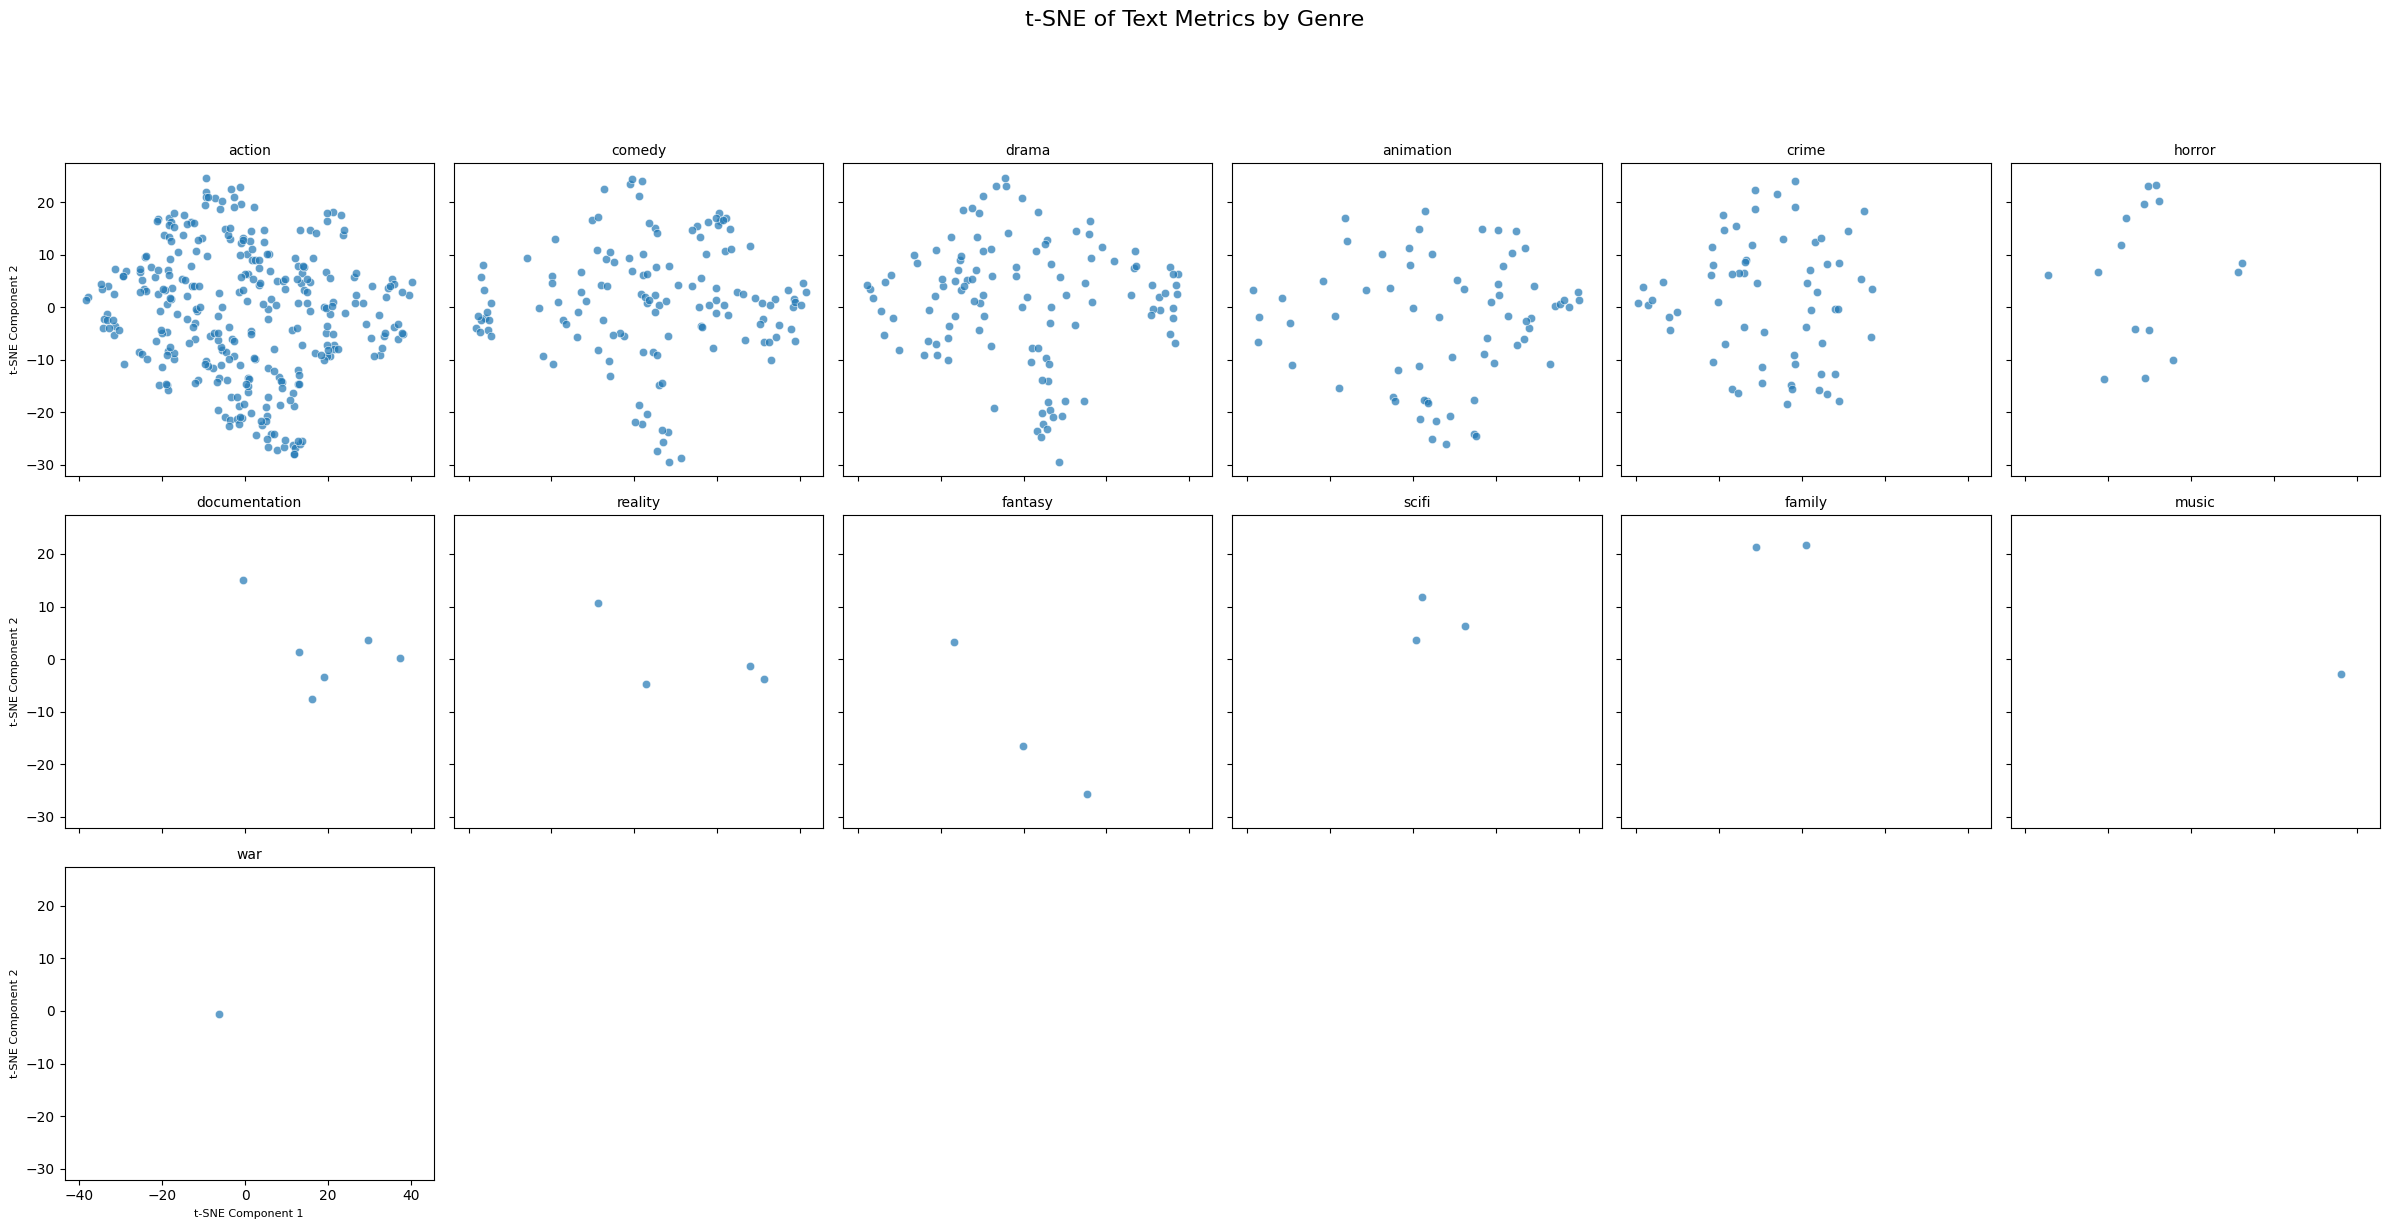

In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Included attributes
features = [
    'description_sentiment', 'title_sentiment',
    'description_neutrality', 'title_neutrality',
    'description_ari', 'title_ari',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count'
]

# Filter columns with 'top_one_genre'
filtered_data = df.dropna(subset=features + ['top_one_genre']).copy()

# Get the top 18 genres
genre_counts = filtered_data['top_one_genre'].value_counts()
top_genres = list(genre_counts.index)
if len(top_genres) > 18:
    top_genres = top_genres[:18]
filtered_data = filtered_data[filtered_data['top_one_genre'].isin(top_genres)]

# Standardize data to prep for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(filtered_data[features])

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(data_scaled)
filtered_data['tsne1'] = tsne_components[:, 0]
filtered_data['tsne2'] = tsne_components[:, 1]

n_genres = len(top_genres)
n_cols = 6
n_rows = math.ceil(n_genres / n_cols)

# Visualize
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# One t-SNE plot per genre
for i, genre in enumerate(top_genres):
    genre_data = filtered_data[filtered_data['top_one_genre'] == genre]
    sns.scatterplot(data=genre_data, x='tsne1', y='tsne2', ax=axes[i], alpha=0.7)
    axes[i].set_title(genre, fontsize=10)
    axes[i].set_xlabel("t-SNE Component 1", fontsize=8)
    axes[i].set_ylabel("t-SNE Component 2", fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("t-SNE of Text Metrics by Genre", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [5]:
##### Let's do some analysis into how likely there is a pattern within each genre based on the t-SNE clustering.

# I've created a "pattern metric" that calculates how far the centroid of a certain genre's clustering is from the
# trivial center, [0,0]. This yields us an interval attribute we can use to compare the "pattern-ness" of genres
# based on their text metrics.

import numpy as np
from scipy.stats import skew

def compute_pattern_metric(df, x_col='tsne1', y_col='tsne2', genre_col='top_one_genre', min_points=50):
    pattern_metrics = {}
    genres = df[genre_col].unique()
    for genre in genres:
        # Pull a single genre (current genre)
        genre_data = df[df[genre_col].str.lower() == genre.lower()]
        if len(genre_data) < min_points:
            continue

        # Compute centroid of the cluster based on the t-SNE dimensions
        centroid_x = np.mean(genre_data[x_col])
        centroid_y = np.mean(genre_data[y_col])
        centroid_displacement = np.sqrt(centroid_x**2 + centroid_y**2)

        # Compute asymmetry about the x-axis
        mean_x = np.mean(genre_data[x_col])
        median_x = np.median(genre_data[x_col])
        asymmetry = abs(mean_x - median_x)

        # Calculate our final pattern metric (weighted sum of displacement and asymmetry)
        # I've weighted centroid displacement more because a global shift in data is likely more significant
        # in telling a pattern for text metrics during clustering than asymmetric data is
        pattern_metric = centroid_displacement * 0.65 + asymmetry * 0.35

        pattern_metrics[genre] = {
            'n_points': len(genre_data),
            'centroid_displacement': centroid_displacement,
            'asymmetry_tsne1': asymmetry,
            'pattern_metric': pattern_metric
        }
    return pattern_metrics

pattern_metrics = compute_pattern_metric(filtered_data)

# Print values
print("Pattern Metric for each genre (higher means more shifted from center and asymmetric):\n")
for genre, metrics in pattern_metrics.items():
    print(f"Genre: {genre}")
    print(f"  Number of points: {metrics['n_points']}")
    print(f"  Centroid displacement from (0,0): {metrics['centroid_displacement']:.3f}")
    print(f"  Asymmetry (|mean - median| on tsne1): {metrics['asymmetry_tsne1']:.3f}")
    print(f"  Composite Pattern Metric: {metrics['pattern_metric']:.3f}\n")

# Mean for pattern metric values
mean_pattern_metric = np.mean([metrics['pattern_metric'] for metrics in pattern_metrics.values()])
print(f"Mean Pattern Metric across all genres: {mean_pattern_metric:.3f}")

Pattern Metric for each genre (higher means more shifted from center and asymmetric):

Genre: comedy
  Number of points: 133
  Centroid displacement from (0,0): 4.811
  Asymmetry (|mean - median| on tsne1): 0.271
  Composite Pattern Metric: 3.222

Genre: crime
  Number of points: 63
  Centroid displacement from (0,0): 8.387
  Asymmetry (|mean - median| on tsne1): 1.046
  Composite Pattern Metric: 5.817

Genre: animation
  Number of points: 65
  Centroid displacement from (0,0): 8.127
  Asymmetry (|mean - median| on tsne1): 1.420
  Composite Pattern Metric: 5.779

Genre: action
  Number of points: 307
  Centroid displacement from (0,0): 1.235
  Asymmetry (|mean - median| on tsne1): 0.273
  Composite Pattern Metric: 0.898

Genre: drama
  Number of points: 114
  Centroid displacement from (0,0): 1.149
  Asymmetry (|mean - median| on tsne1): 0.290
  Composite Pattern Metric: 0.849

Mean Pattern Metric across all genres: 3.313


Top 2 pattern metric genres: ['crime', 'animation']


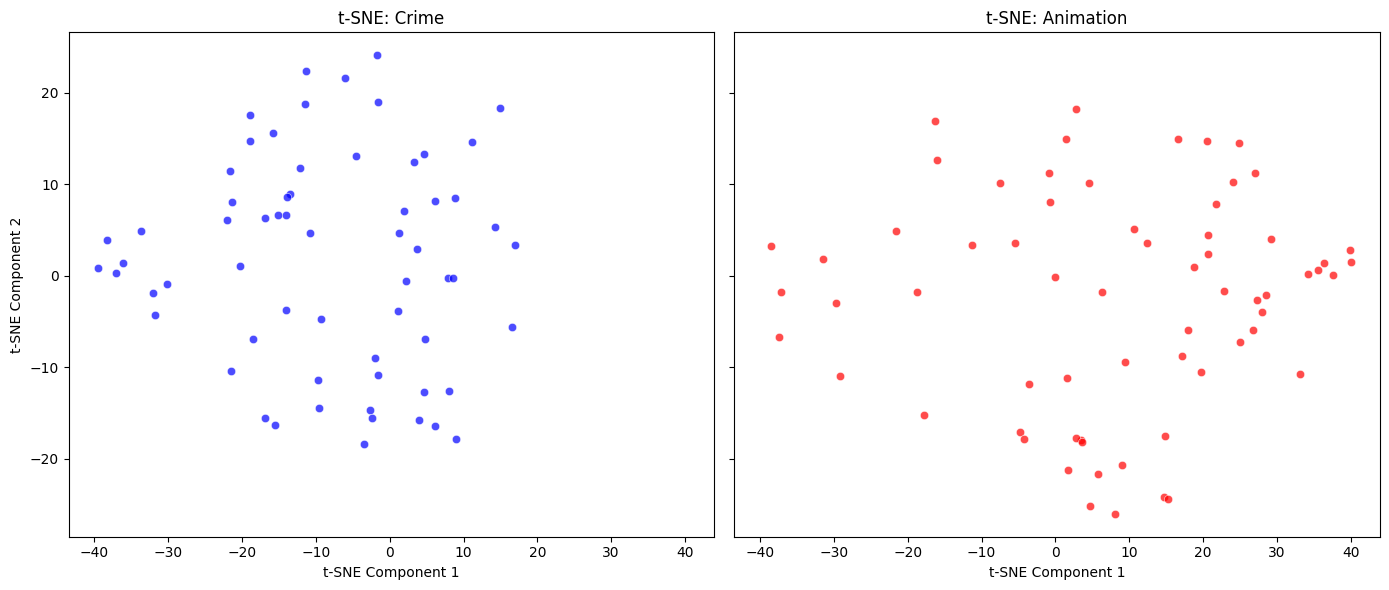

In [6]:
##### Getting plots for specifically the two genres that yielded the highest pattern values.
top2 = sorted(pattern_metrics.items(), key=lambda x: x[1]['pattern_metric'], reverse=True)[:2]
top2_genres = [genre for genre, metrics in top2]

print("Top 2 pattern metric genres:", top2_genres)

# Filter the filtered_data DataFrame to only include the top 2 genres
genre1_data = filtered_data[filtered_data['top_one_genre'].str.lower() == top2_genres[0].lower()]
genre2_data = filtered_data[filtered_data['top_one_genre'].str.lower() == top2_genres[1].lower()]

# Plot t-SNE for the top 2 genres side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

sns.scatterplot(data=genre1_data, x='tsne1', y='tsne2', ax=axes[0], alpha=0.7, color='blue')
axes[0].set_title(f"t-SNE: {top2_genres[0].capitalize()}")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")

sns.scatterplot(data=genre2_data, x='tsne1', y='tsne2', ax=axes[1], alpha=0.7, color='red')
axes[1].set_title(f"t-SNE: {top2_genres[1].capitalize()}")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()



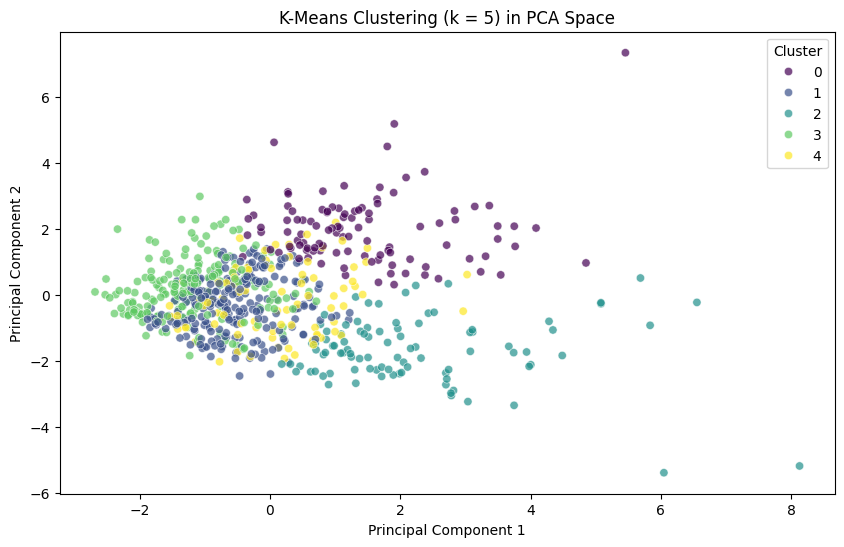

Cluster centroids (standardized features):
[[-0.04783874 -0.01244613  0.20068246 -0.1413162  -0.33434718 -0.09999218
  -0.08001672  1.75109983 -0.10665869  1.70951215]
 [ 0.09865311  0.20260525  0.76177246  0.17619747  0.15355057  0.29588127
  -0.37167384 -0.41972511 -0.35491831 -0.32915126]
 [ 0.17812029  0.18024003  0.51110366  0.27859246 -0.09985536 -0.21368086
   1.96224351  0.01063832  1.94500042 -0.02659818]
 [-1.01877655 -0.4793089  -0.80078322 -0.28830819 -0.03091987 -0.2386236
  -0.39656268 -0.40530417 -0.39764347 -0.48015563]
 [ 1.78071171  0.32586765 -1.01657773  0.03828231  0.16224232  0.08010581
  -0.11536921 -0.1117205  -0.10750707 -0.09937612]]


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define the features and load the data (using your prepared DataFrame 'df')
features = [
    'description_sentiment', 'title_sentiment',
    'description_neutrality', 'title_neutrality',
    'description_ari', 'title_ari',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count'
]

# Create a working DataFrame with non-null features and a genre column
data = df[features + ['top_one_genre']].dropna()

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
data['pca1'] = pca_result[:, 0]
data['pca2'] = pca_result[:, 1]

# Perform K-means clustering on the standardized features
k = 5  # choose the number of clusters; adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data['cluster'] = clusters

# Visualize the clusters using the PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='pca1', y='pca2', hue='cluster', palette='viridis', alpha=0.7)
plt.title("K-Means Clustering (k = {}) in PCA Space".format(k))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Print out the cluster centroids in the standardized feature space
print("Cluster centroids (standardized features):")
print(kmeans.cluster_centers_)


Results by Genre:
       Genre  Observed Avg Distance  p-value  95% CI Lower  95% CI Upper
0     action               6.083832    0.000      1.210319      4.038491
1     comedy               7.001012    0.000      1.218270      4.876220
2      drama               5.977177    0.001      1.263420      4.996282
3  animation               9.512446    0.000      1.262570      5.980515
4      crime              11.508277    0.000      1.281648      6.431497


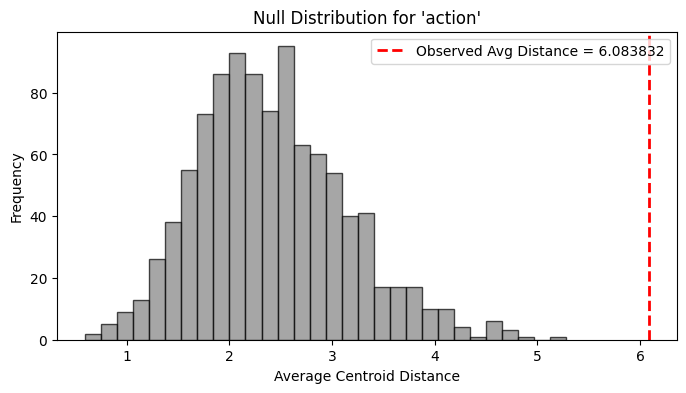

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Functions to compute centroids and average distances ---

def compute_genre_centroids(df, genre_col, tsne_cols):
    """
    Computes the centroid (mean of t-SNE coordinates) for each genre in the DataFrame.
    """
    centroids = {}
    for genre, group in df.groupby(genre_col):
        centroids[genre] = group[tsne_cols].mean().values
    return centroids

def compute_avg_distance_for_genre(centroids, target_genre):
    """
    Computes the average Euclidean distance from the centroid of target_genre to the centroids of all other genres.
    """
    target_centroid = centroids[target_genre]
    distances = []
    for genre, centroid in centroids.items():
        if genre != target_genre:
            distances.append(np.linalg.norm(target_centroid - centroid))
    return np.mean(distances)

def compute_observed_avg_distances(df, genre_col, tsne_cols):
    """
    Computes the observed centroids and, for each genre, the average distance to all other centroids.
    """
    centroids = compute_genre_centroids(df, genre_col, tsne_cols)
    avg_distances = {}
    for genre in centroids.keys():
        avg_distances[genre] = compute_avg_distance_for_genre(centroids, genre)
    return avg_distances, centroids

# --- Permutation test function ---

def permutation_test_avg_distance(df, genre_col, tsne_cols, genres, n_permutations=1000, random_state=None):
    """
    For each genre (from the list 'genres'), performs a permutation test.
    In each permutation, the genre labels are shuffled (preserving the overall label distribution),
    the centroids are recalculated, and the average distance for each genre is computed.

    Returns a dictionary where each key is a genre and the value is an array of permuted average distances.
    """
    # Dictionary to hold permutation results for each genre
    permuted_avg_distances = {genre: [] for genre in genres}

    # Set the random seed if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Get the array of labels so we can shuffle them.
    labels = df[genre_col].values.copy()

    # Perform permutations
    for _ in range(n_permutations):
        # Permute labels to break any association with the t-SNE coordinates
        permuted_labels = np.random.permutation(labels)
        df_permuted = df.copy()
        df_permuted[genre_col] = permuted_labels

        # Filter to keep only the genres we are testing (should be the same as 'genres')
        df_permuted = df_permuted[df_permuted[genre_col].isin(genres)]

        # Recompute centroids for the permuted labels
        centroids_perm = compute_genre_centroids(df_permuted, genre_col, tsne_cols)

        # (If for some reason a genre is missing, skip this permutation.)
        if set(centroids_perm.keys()) != set(genres):
            continue

        # Compute and store the average distance for each genre in this permutation
        for genre in genres:
            avg_dist = compute_avg_distance_for_genre(centroids_perm, genre)
            permuted_avg_distances[genre].append(avg_dist)

    # Convert lists to numpy arrays for later calculations
    for genre in permuted_avg_distances:
        permuted_avg_distances[genre] = np.array(permuted_avg_distances[genre])
    return permuted_avg_distances

# --- Main analysis ---

# Assume 'filtered_data' is your DataFrame that contains the t-SNE coordinates and the genre column.
# Also assume that the t-SNE columns are named 'tsne1' and 'tsne2', and the genre column is 'top_one_genre'.

# Filter the DataFrame for genres with at least 50 observations.
genre_counts = filtered_data['top_one_genre'].value_counts()
genres_over_50 = genre_counts[genre_counts >= 50].index.tolist()

# Select only rows belonging to these genres.
df_test = filtered_data[filtered_data['top_one_genre'].isin(genres_over_50)].copy()

# Define the t-SNE coordinate columns.
tsne_cols = ['tsne1', 'tsne2']

# Compute the observed average distances for each genre.
observed_avg_distances, observed_centroids = compute_observed_avg_distances(df_test, 'top_one_genre', tsne_cols)

# Run the permutation test to build a null distribution for each genre's average distance.
n_permutations = 1000
permuted_avg_distances = permutation_test_avg_distance(df_test, 'top_one_genre', tsne_cols, genres_over_50,
                                                       n_permutations=n_permutations, random_state=42)

# For each genre, compute the p-value and 95% confidence interval from the null distribution.
results = []
for genre in genres_over_50:
    obs_val = observed_avg_distances[genre]
    null_dist = permuted_avg_distances[genre]
    # p-value: proportion of permutations where the average distance is at least as extreme as observed
    p_val = np.mean(null_dist >= obs_val)
    # 95% CI from the null distribution (percentile method)
    ci_lower, ci_upper = np.percentile(null_dist, [2.5, 97.5])
    results.append({
        'Genre': genre,
        'Observed Avg Distance': obs_val,
        'p-value': p_val,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper
    })

results_df = pd.DataFrame(results)
print("Results by Genre:")
print(results_df)

# Optionally, visualize the null distribution for one genre (e.g., the first one)
example_genre = results_df.iloc[0]['Genre']
plt.figure(figsize=(8, 4))
plt.hist(permuted_avg_distances[example_genre], bins=30, alpha=0.7, color='gray', edgecolor='black')
plt.axvline(observed_avg_distances[example_genre], color='red', linestyle='dashed', linewidth=2,
            label=f'Observed Avg Distance = {observed_avg_distances[example_genre]:.6f}')
plt.xlabel("Average Centroid Distance")
plt.ylabel("Frequency")
plt.title(f"Null Distribution for '{example_genre}'")
plt.legend()
plt.show()
